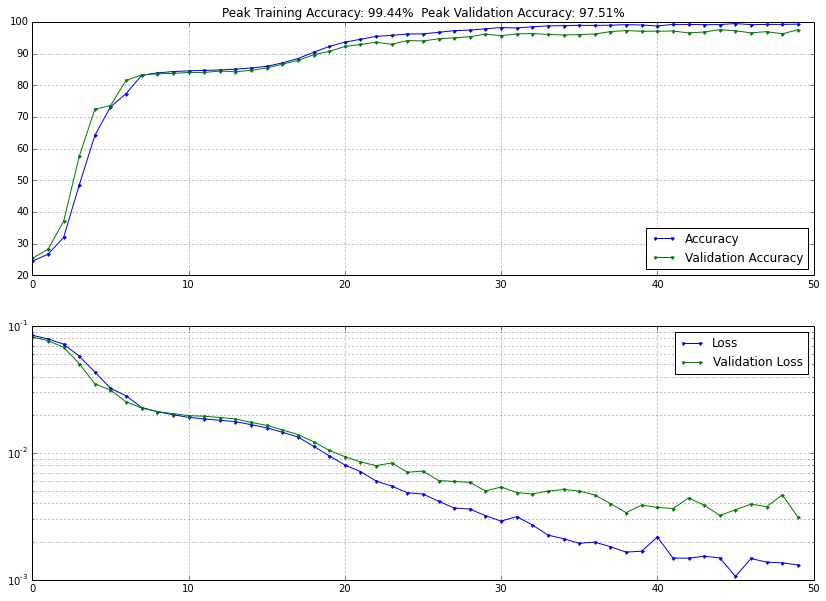

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sensors_ini.rnns.lasagne_utils import save_model, store_in_log, load_model, load_log, replace_updates_nans_with_zero

# One to investigate:
filename = 'lipreading_grid_audio_1_recent'

# Load history from file
history = load_log(filename)

plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
plt.plot(history['train_acc'], '.-')
plt.plot(history['val_acc'], '.-')
#plt.plot(history['val_no_aud_acc'], '.-')
#plt.plot(history['val_no_vid_acc'], '.-')
plt.legend(['Accuracy', 'Validation Accuracy'],loc='lower right')
plt.title('Peak Training Accuracy: {:.2f}%  Peak Validation Accuracy: {:.2f}%'.format(np.max(history['train_acc']),np.max(history['val_acc'])))
plt.grid(which='both')

plt.subplot(2,1,2)
plt.semilogy(history['train_err'], '.-')
plt.semilogy(history['val_err'], '.-')
#plt.semilogy(history['val_no_aud_err'], '.-')
#plt.semilogy(history['val_no_vid_err'], '.-')
plt.legend(['Loss', 'Validation Loss'])
plt.grid(which='both')
plt.savefig('grid_accuracy_history.png')

In [11]:
import numpy as np
import theano.tensor as T
import theano
import glob
from lipreading_utils import find_data_mean, find_data_std, HDF5LipReadingIterator, HDF5LipReadingIterator_events,\
                             ftensor5, get_train_and_val_fn, vocab_size, print_model_with_data
from lipreading_models import get_dan_original_rnn, get_network,get_dan_original_audio
import h5py

#h5file = '/media/yy/Seagate Expansion Drive1/hwGrid_20 (copy).hdf5'
h5file='/home/yy/thesis/workspace/cochlp_6_17.hdf5'
# Get the same random data split
np.random.seed(42)   
# Get dataset
log = load_log(filename)

# Load dataset
dataset = h5py.File(h5file, "r")

print('Train set size: {} sentences.'.format(len(dataset['train_labels'])))
print('Test set size: {} sentences.'.format(len(dataset['test_labels'])))

# Load network
aud_in   = T.ftensor3('aud_in')
vid_in   = ftensor5('vid_in')
targets  = T.fmatrix('targets')
network = get_dan_original_audio(aud_in)
load_model(filename, network)

# Get data iterator
d = HDF5LipReadingIterator()

# Compile the output fn
print('Compiling output functions...')
train_fn, val_fn, out_fn = get_train_and_val_fn([aud_in], targets, network)
print('Compiled.')

# Load a data
for data in d.flow(dataset, 'train', batch_size=7, shuffle=False, blankout=0):

    aud_in, aud_mask, vid_in, vid_mask, bY = data
    output = out_fn(aud_in)
    err, acc,debug_var2 = val_fn(aud_in, bY)
    break
print('Data prepped and passed through.')
print(acc)
print(debug_var2)

Train set size: 93 sentences.
Test set size: 7 sentences.
Compiling output functions...


KeyboardInterrupt: 

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


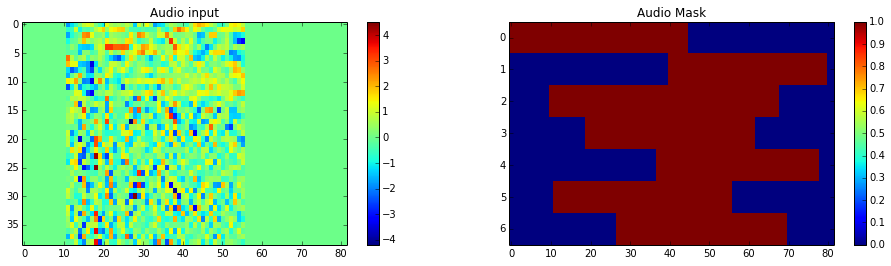

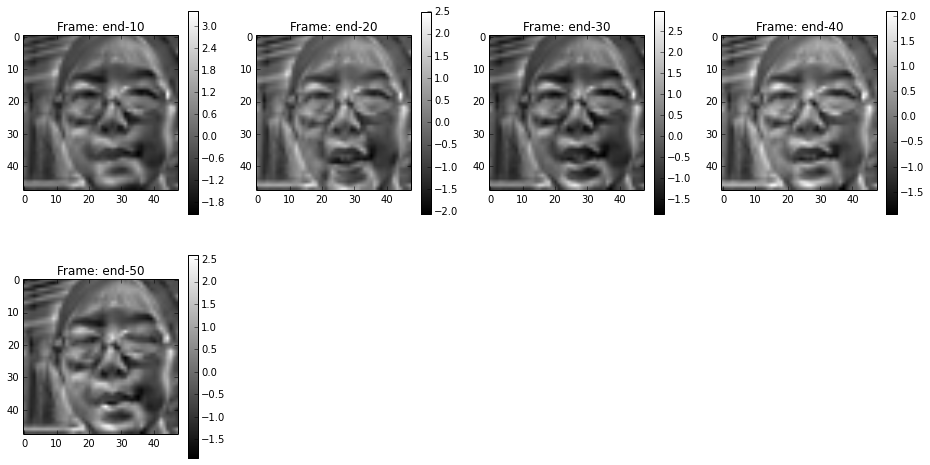

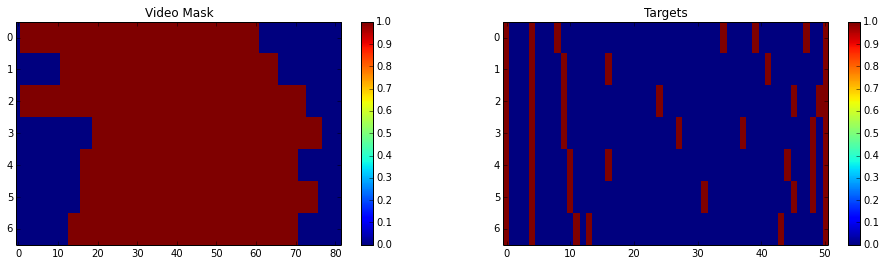

In [5]:
idx = 5


plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(aud_in[idx].T, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio input')

plt.subplot(1,2,2)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio Mask')

plt.figure(figsize=(16,8))
# Get padded max length
max_len = vid_in.shape[1]
for i in range(5):
    plt.subplot(2,4,i+1)
    plt.imshow(np.squeeze(vid_in[idx][-(i+1)*10]), cmap='gray')
    plt.title('Frame: end-{}'.format((i+1)*10))
    plt.colorbar()

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(vid_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Video Mask')

plt.subplot(1,2,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Targets')

In [ ]:
print_model_with_data(network, output)

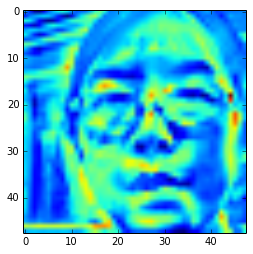

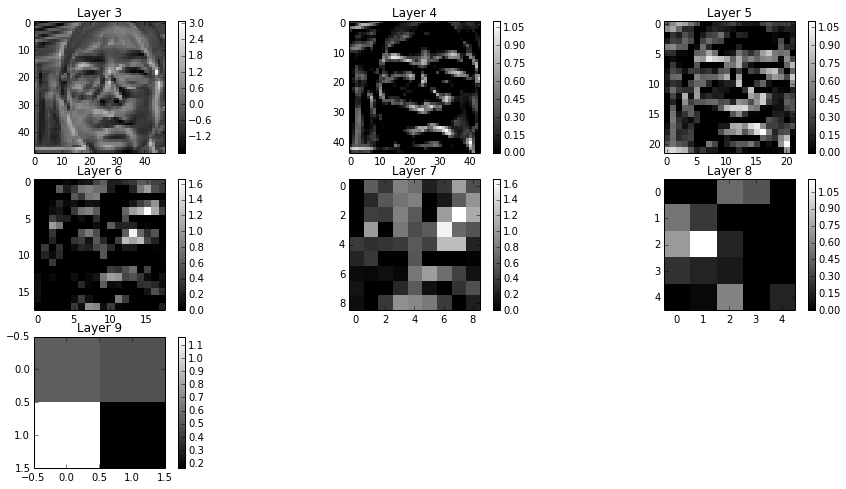

In [6]:
plt.figure(figsize=(4,4))
plt.imshow(np.squeeze(output[3][117]))

plt.figure(figsize=(16,8))
for i in range(3,10):
    plt.subplot(3,3,i-3+1)
    plt.imshow(output[i][117][0], interpolation='nearest', cmap='gray')
    plt.colorbar()
    plt.title('Layer {}'.format(i))
#plt.savefig('face_through_layers.png')

In [3]:
idx = 0
print(output[17].shape)
plt.figure(figsize=(16,8))
plt.imshow(output[17][idx].T, interpolation='nearest',aspect='auto')
plt.colorbar()
plt.title('Merged Audio and Video Features')
#plt.savefig('merged_features.png')

NameError: name 'output' is not defined

Network guess: bin green with s 3 again
True: bin blue at y 3 again soon
Network guess: bin blue at 1 zero again
True: bin blue by d 5 soon
Network guess: bin blue by f again
True: bin blue by l 9 please soon
Network guess: green 1 soon
True: bin blue by q 1 now soon
Network guess: bin blue at 4 now
True: bin blue in d 8 now soon
Network guess: bin blue with e 5 now
True: bin blue in u 9 now soon
Network guess: bin green with 7 soon
True: bin blue with c 7 soon


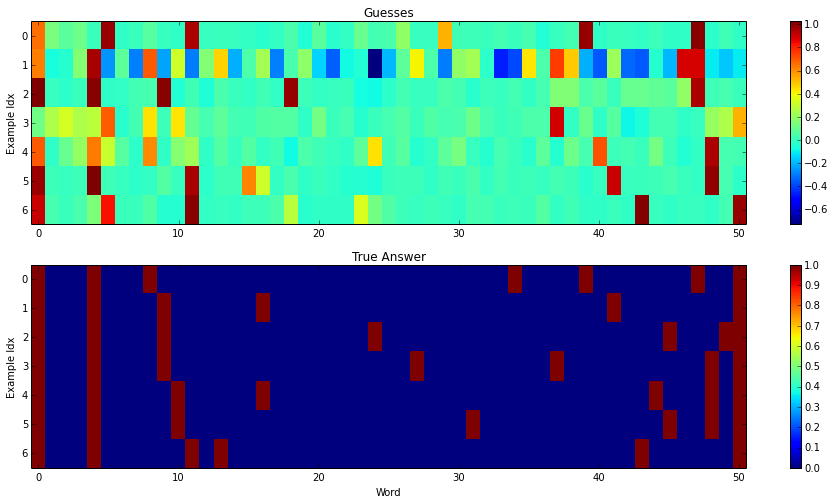

In [9]:
from lipreading_utils import bow_to_said_list
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.imshow(output[-1], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Guesses')
plt.ylabel('Example Idx')
plt.subplot(2,1,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('True Answer')
plt.ylabel('Example Idx')
plt.xlabel('Word')

for idx in range(7):
    # Extract bag-of-words of interest
    bow = output[-1][idx]
    # Find the chosen words
    print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #plt.savefig('network_guesses.png')

In [ ]:
bow = output[-1][0]
target_var=bY[0]
print(bow)
test_prediction_thresholded = np.where(output[-1]>0.5, 1.0, 0.0)
print(test_prediction_thresholded)
sum_of_targets = np.sum(bY,axis=1)
test_mean_mismatch_per_example = np.sum(abs(test_prediction_thresholded-bY), axis=1)/sum_of_targets
test_acc = 1.-np.mean(test_mean_mismatch_per_example)
print(test_acc)

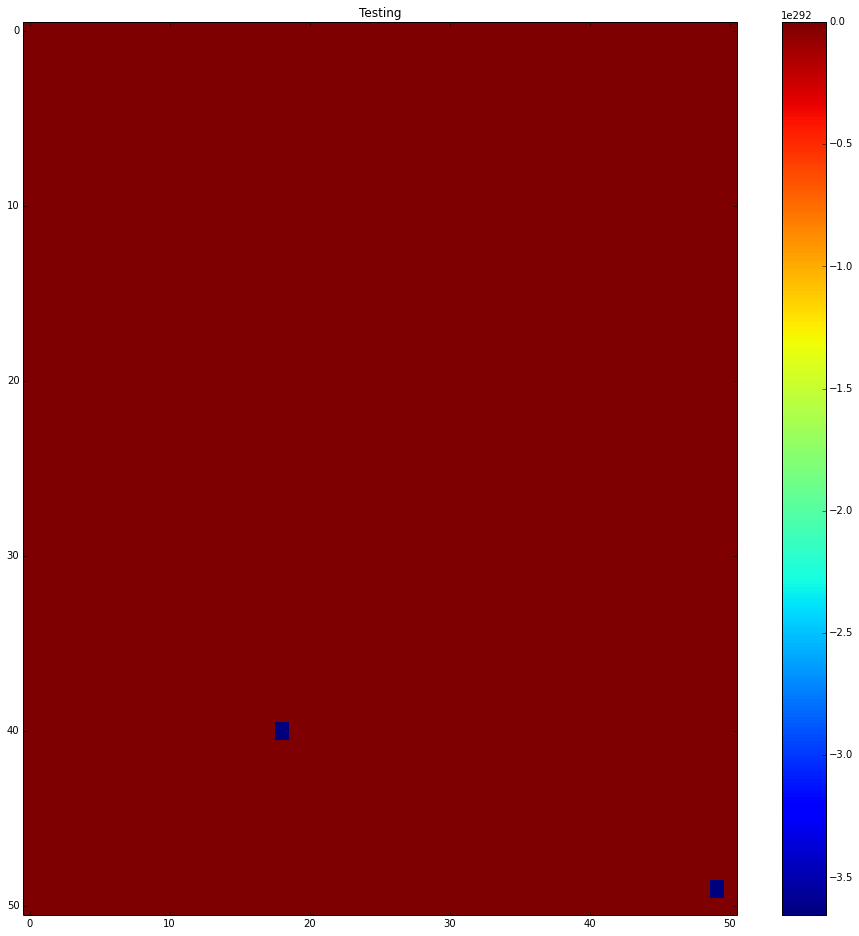

In [11]:
#confusion matrix
#testing
from lipreading_utils import bow_to_said_list
# Load a data
for data in d.flow(dataset, 'test', batch_size=7, shuffle=False, blankout=0.0):
    aud_in, aud_mask, vid_in, vid_mask, bY = data
    output = out_fn(aud_in, vid_in)
    break
plt.figure(figsize=(16,16))
con_mat_train=np.empty([51, 51])
for idx in range(7):
    # Extract bag-of-words of interest
    bow = output[-1][idx]
    # Find the chosen words
    #print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #plt.savefig('network_guesses.png')
    pred=np.where(bow>0.5, 1, 0)
    label=bY[idx]
    #print(pred)
    #print(label)
    pred_ind=np.where(pred==1)
    label_ind=np.where(label==1)
    #print(len(pred_ind[0])-1)
    #print(len(label_ind[0])-1)
    for i in range(len(pred_ind[0])-1):
        
        con_mat_train[pred_ind[0][i]][label_ind[0][i]]=con_mat_train[pred_ind[0][i]][label_ind[0][i]]+1

plt.imshow(con_mat_train, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Testing')    

In [ ]:
#confusion matrix
#training
from lipreading_utils import bow_to_said_list
# Load a data
for data in d.flow(dataset, 'train', batch_size=2000, shuffle=True, blankout=0.0):
    aud_in, aud_mask, vid_in, vid_mask, bY = data
    output = out_fn(aud_in, vid_in)
    break
plt.figure(figsize=(16,16))
con_mat_train=np.empty([51, 51])
for idx in range(2000):
    # Extract bag-of-words of interest
    bow = output[-1][idx]
    # Find the chosen words
    #print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #plt.savefig('network_guesses.png')
    pred=np.where(bow>0.5, 1, 0)
    label=bY[idx]
    #print(pred)
    #print(label)
    pred_ind=np.where(pred==1)
    label_ind=np.where(label==1)
    #print(len(pred_ind[0])-1)
    #print(len(label_ind[0])-1)
    for i in range(len(pred_ind[0])-1):
        
        con_mat_train[pred_ind[0][i]][label_ind[0][i]]=con_mat_train[pred_ind[0][i]][label_ind[0][i]]+1

plt.imshow(con_mat_train, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Training')        
    